In [1]:
%matplotlib inline
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import requests
from scipy.stats import linregress
from pprint import pprint
import scipy.stats as st
import scipy.stats as stats
from citipy import citipy

import gmaps

# Import API key
from api_keys import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)

In [2]:
# Mobility data
mobility_file = "data/2020_AU_Region_Mobility_Report.csv"
mobility_df = pd.read_csv(mobility_file)

mobility_df.head(3)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-15,4.0,3.0,-2.0,3.0,3.0,0.0
1,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-16,3.0,5.0,9.0,3.0,-1.0,0.0
2,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-17,-1.0,0.0,-6.0,7.0,17.0,-2.0


In [3]:
# Covid data
covid_file = "data/covid-19-all.csv"
covid_df = pd.read_csv(covid_file)

covid_df.head(3)

C:\Users\arron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,NaN,NaN,NaN,NaN,51526.0,41727.0,2191.0,2021-01-01
1,NaN,NaN,NaN,NaN,58316.0,33634.0,1181.0,2021-01-01
2,NaN,NaN,NaN,NaN,99897.0,67395.0,2762.0,2021-01-01


### 1.1 Cleansing Mobility data and grouping data to state level

In [4]:
# Format "Date" to datetime
mobility_df["date"]=pd.to_datetime(mobility_df["date"])

In [5]:
# Mobililty data is at sub-region_2 level. Therefore, mean or median of mobility index is calculated group by state and date
stategrp_df = mobility_df.groupby(["country_region","sub_region_1","date"])

retail_recreation = stategrp_df.retail_and_recreation_percent_change_from_baseline.median()
grocery_pharmacy = stategrp_df.grocery_and_pharmacy_percent_change_from_baseline.median()
parks = stategrp_df.parks_percent_change_from_baseline.median()
transit_stations = stategrp_df.transit_stations_percent_change_from_baseline.median()
workplaces = stategrp_df.workplaces_percent_change_from_baseline.median()
residential = stategrp_df.residential_percent_change_from_baseline.median()

# New state dataframe
state_mobility_df = pd.DataFrame({"retail_recreation_pctchange_to_baseline": retail_recreation,
                                    "grocery_pharmacy_pctchange_to_baseline": grocery_pharmacy,
                                    "parks_pctchange_to_baseline": parks,
                                    "transit_stations_pctchange_to_baseline": transit_stations,
                                    "workplaces_pctchange_to_baseline": workplaces,
                                    "residential_pctchange_to_baseline": residential
                                    }) 
#Reset index
state_mobility_df = state_mobility_df.reset_index()

#Rename columns
state_mobility_df = state_mobility_df.rename(columns={"sub_region_1":"state"})

state_mobility_df.head(3)

,country_region,state,date,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,Australian Capital Territory,2020-02-15,7.0,5.0,28.0,4.0,6.0,-1.0
1,Australia,Australian Capital Territory,2020-02-16,8.0,19.0,34.0,16.0,2.0,-2.0
2,Australia,Australian Capital Territory,2020-02-17,-1.0,10.0,9.0,21.0,25.0,-4.0


### 1.2 Create & Cleansing AU Covid Dataframe

In [6]:
columns = ["Country/Region","Province/State","Latitude","Longitude","Date","Confirmed","Deaths"]

au_covid_df = covid_df.loc[covid_df["Country/Region"]=="Australia",columns]

#Reset index
au_covid_df = au_covid_df.reset_index(drop=True)

au_covid_df.head()

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,NaN,NaN
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,NaN
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,NaN
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,NaN
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,NaN


In [7]:
# Replace n/a Covid case number with zero
au_covid_df["Confirmed"]=au_covid_df["Confirmed"].fillna(0)
au_covid_df["Deaths"]=au_covid_df["Deaths"].fillna(0)

au_covid_df.head()

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0


In [8]:
# Format "Date" to datetime
au_covid_df["Date"]=pd.to_datetime(au_covid_df["Date"])

au_covid_df.tail(3)

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
2593,Australia,Tasmania,-42.8821,147.3272,2020-12-31,234.0,13.0
2594,Australia,Victoria,-37.8136,144.9631,2020-12-31,20376.0,820.0
2595,Australia,Western Australia,-31.9505,115.8605,2020-12-31,861.0,9.0


In [9]:
#Rename columns
au_covid_df = au_covid_df.rename(columns={"Country/Region":"country_region", "Province/State":"state", "Date":"date"})


In [10]:
au_covid_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0


### 1. 3 Final Working Dataframe

In [11]:
# Merge the two dataframe together with all covid data outer join 
working_df = pd.merge(au_covid_df,state_mobility_df, how="left",on=["country_region", "state", "date"])

working_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Mobility with N/A is considered as baseline. Therefore, update all N/A to be zero
working_df["retail_recreation_pctchange_to_baseline"]=working_df["retail_recreation_pctchange_to_baseline"].fillna(0)
working_df["grocery_pharmacy_pctchange_to_baseline"]=working_df["grocery_pharmacy_pctchange_to_baseline"].fillna(0)
working_df["parks_pctchange_to_baseline"]=working_df["parks_pctchange_to_baseline"].fillna(0)
working_df["transit_stations_pctchange_to_baseline"]=working_df["transit_stations_pctchange_to_baseline"].fillna(0)
working_df["workplaces_pctchange_to_baseline"]=working_df["workplaces_pctchange_to_baseline"].fillna(0)
working_df["residential_pctchange_to_baseline"]=working_df["residential_pctchange_to_baseline"].fillna(0)

working_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.1 Arron's Section

The first step is to look at the number of confirmed cases for Austrlia in 2020. We want to see the spread of these data and how they look overtime.


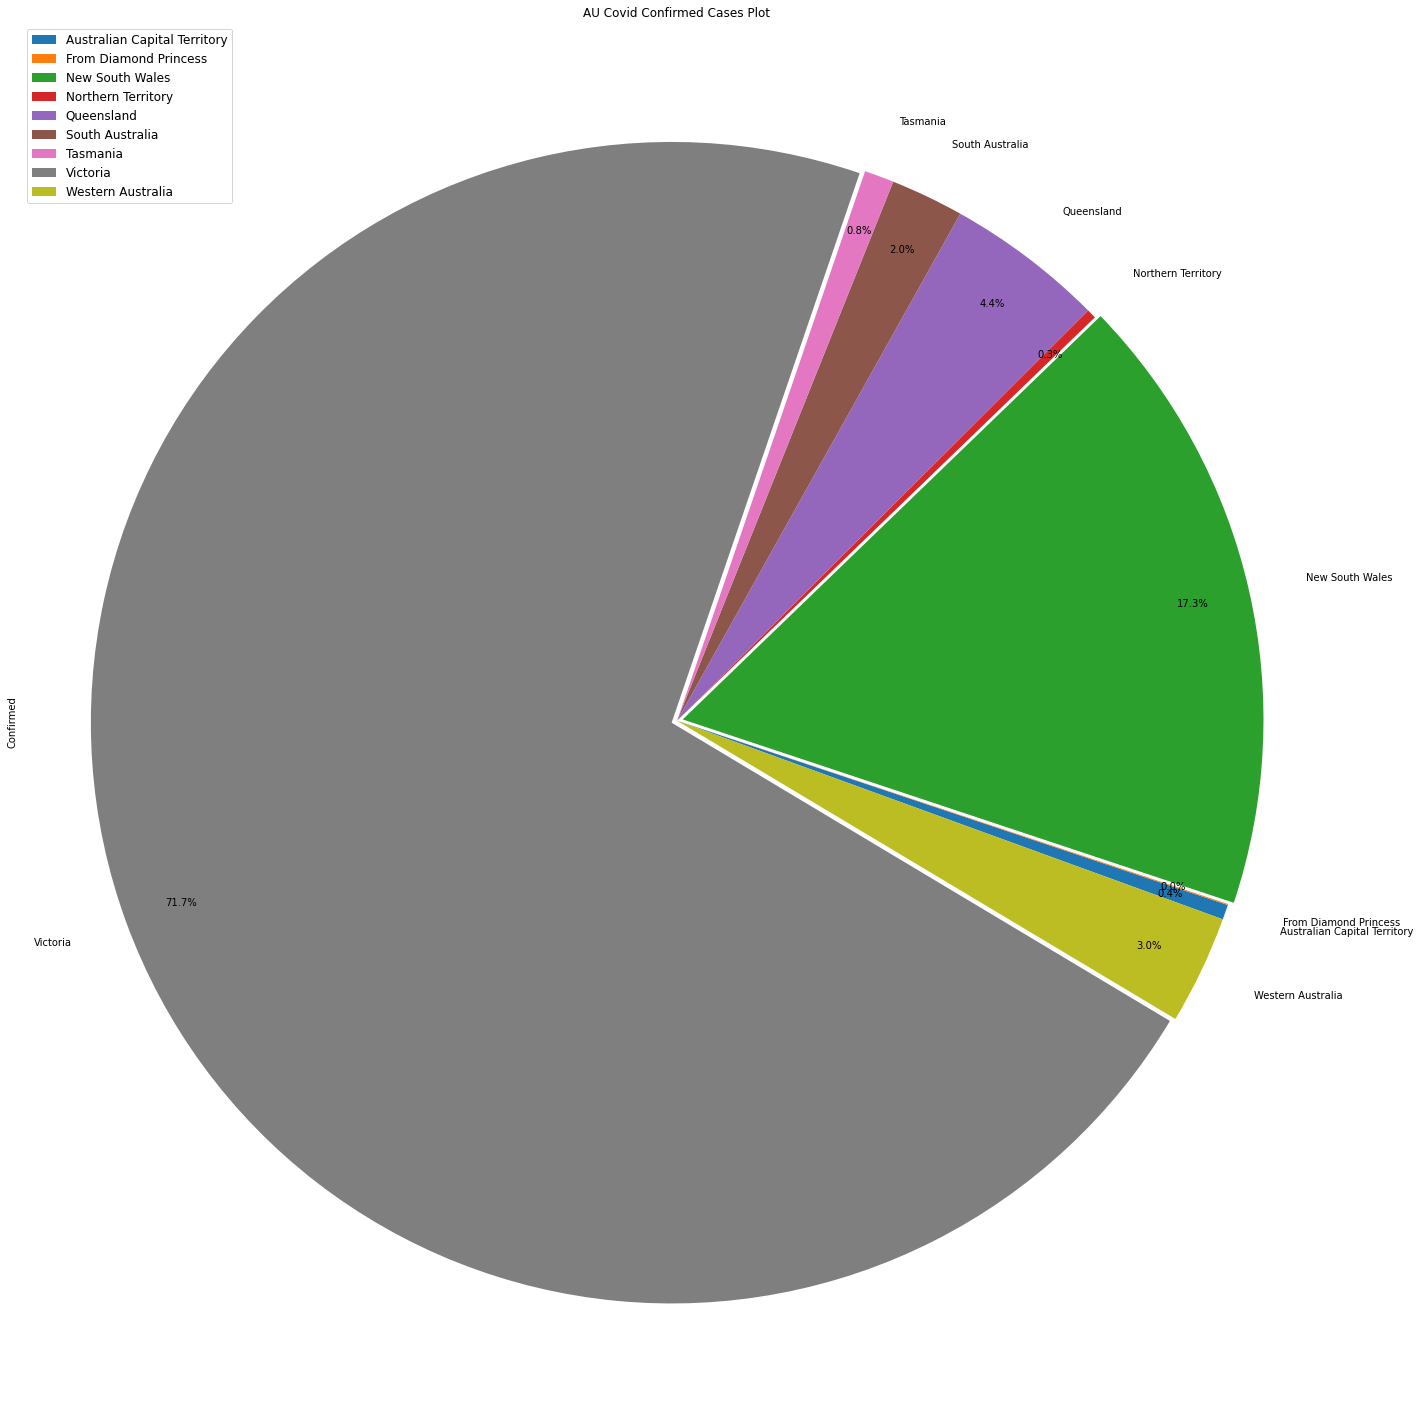

In [13]:
# A simple Pie Chart to show the split of covid cases in Australia amongst the various regions affected

# Groupby to get the maximum Confirmed case for every state
confirmed_df = working_df.groupby('state')['Confirmed'].max()
confirmed_df = pd.DataFrame(confirmed_df)

#Drop any zero values with references
confirmed_df = confirmed_df[(confirmed_df.T !=0).any()]

confirmed_df

# plot pie chart
explode = (0,0,0.01,0,0,0,0,0.01,0)

plot = confirmed_df.plot.pie(y='Confirmed',figsize=(20,20), explode =explode, startangle=700, autopct="%1.1f%%",pctdistance=0.9, labeldistance=1.1)
plt.title("AU Covid Confirmed Cases Plot")
plt.rc('font', size=12)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=20)
plt.legend(loc="upper left", fontsize=12)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [14]:
# Do the analysis on the categories that we would want to investigate further

In [15]:
confirmed_df

,Confirmed
state,
Australian Capital Territory,118.0
From Diamond Princess,8.0
New South Wales,4928.0
Northern Territory,75.0
Queensland,1253.0
South Australia,580.0
Tasmania,234.0
Victoria,20376.0
Western Australia,861.0


## 2.2 Create Google Heatmap To Show Confirmed Cases By States

In [16]:
# Groupby Lat & Long to get coordinates
heatmap_df_1 = working_df.groupby(["Latitude"])
heatmap_df_2 = working_df.groupby(["Longitude"])

# Get the max values for confirmed cases
heatmap_df_1 = heatmap_df_1.Confirmed.max()
heatmap_df_2 = heatmap_df_2.Confirmed.max()

# Convert into Dataframes
heatmap_df_1 = pd.DataFrame(heatmap_df_1)
heatmap_df_2 = pd.DataFrame(heatmap_df_2)

# Use index as Lat & Lng Coordinates required for mapping
heatmap_df_1['lat'] = heatmap_df_1.index
heatmap_df_2['lng'] = heatmap_df_2.index

# Merge dataframe to get values into one dataframe
heatmap_df = pd.merge(heatmap_df_1,heatmap_df_2, how="left")

# Store latitude and longitude in locations
locations = heatmap_df[["lat","lng"]]

# Use total confirmed cases as weight
comfirmed = heatmap_df["Confirmed"].astype(float)

# Plot Heatmap
fig = gmaps.figure()
# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=comfirmed, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=1.5)
# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

## 2.3 Mapping Total Confirmed Cases as Time Series
 - To assess what was the COVID situations for each states for 2020

In [17]:
# Start by Groupby states
act_df = working_df.loc[working_df["state"] == "Australian Capital Territory",:]
nsw_df = working_df.loc[working_df["state"] == "New South Wales",:]
nt_df = working_df.loc[working_df["state"] == "Northern Territory",:]
qld_df = working_df.loc[working_df["state"] == "Queensland",:]
sa_df = working_df.loc[working_df["state"] == "South Australia",:]
tas_df = working_df.loc[working_df["state"] == "Tasmania",:]
vic_df = working_df.loc[working_df["state"] == "Victoria",:]
wa_df = working_df.loc[working_df["state"] == "Western Australia",:]

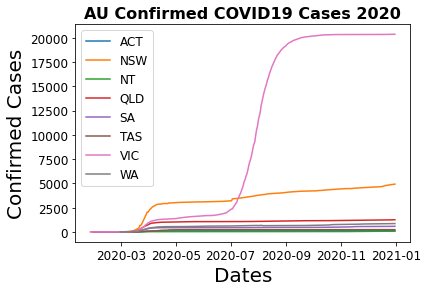

<Figure size 720x3600 with 0 Axes>

In [18]:
#Plotting confirmed cases for all States on the same chart for quick visuals
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['Confirmed']
nsw = nsw_df['Confirmed']
nt = nt_df['Confirmed']
qld = qld_df['Confirmed']
sa = sa_df['Confirmed']
tas = tas_df['Confirmed']
vic = vic_df['Confirmed']
wa = wa_df['Confirmed']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')

plt.legend(loc="upper left")
plt.title("AU Confirmed COVID19 Cases 2020", fontsize=16, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("Confirmed Cases")
plt.figure(figsize=(10, 50))
plt.show()


## Confirmed Cases Analysis 
- Most states had a jump in cases from March - April
- Most states managed their numbers and there confirmed cases line flatten out after the initial growth.
- VIC NSW and QLD were the top 3 states for highest total number of confirmed cases.
- VIC was the most prominant line on the chart. The number of cases continued to grow and hit exponential growth between July - September (our second wave).
- VIC managed to flatten the curve from September onwards.

## 2.4 Mapping Time Series Plot and Ananlysis Each Movement Categories
- The next step is to analyse each category over time and see what trends we can gather for our thesis

In [19]:
# Analysing total average changes accross all Catergories
#Group by states and get yearly averages across all the categories
retail_avg_change = working_df.groupby('state')['retail_recreation_pctchange_to_baseline'].mean()
grocery_avg_change = working_df.groupby('state')['grocery_pharmacy_pctchange_to_baseline'].mean()
parks_avg_change = working_df.groupby('state')['parks_pctchange_to_baseline'].mean()
pt_avg_change = working_df.groupby('state')['transit_stations_pctchange_to_baseline'].mean()
workplace_avg_change = working_df.groupby('state')['workplaces_pctchange_to_baseline'].mean()
home_avg_change = working_df.groupby('state')['residential_pctchange_to_baseline'].mean()

In [20]:
# Merge average changes into one dataframe to compare
avg_change_summary = pd.merge(retail_avg_change,grocery_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,parks_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,pt_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,workplace_avg_change,how="left",on=["state"])
avg_change_summary = pd.merge(avg_change_summary,home_avg_change,how="left",on=["state"])
avg_change_summary = pd.DataFrame(avg_change_summary)
avg_change_summary

,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
state,,,,,,
Australian Capital Territory,-15.108844,1.374150,7.979592,-34.108844,-15.955782,8.642857
External territories,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
From Diamond Princess,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Jervis Bay Territory,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
New South Wales,-10.835294,1.447059,-9.327941,-27.429412,-10.891176,6.785294
Northern Territory,6.387789,14.064356,25.917492,-27.140264,3.049505,2.480198
Queensland,-4.688427,2.345697,-3.913947,-23.713650,-6.942136,4.182493
South Australia,-8.286567,4.492537,-13.688060,-13.026866,-10.076119,5.716418
Tasmania,-18.940984,-8.273770,-43.001639,-41.149180,-8.993443,6.577049


In [21]:
# What was the overall change for all these categories for the year? Which one should we focus on?
retail_avg_net_sum = avg_change_summary['retail_recreation_pctchange_to_baseline'].sum()
grocer_avg_net_sum = avg_change_summary['grocery_pharmacy_pctchange_to_baseline'].sum()
park_avg_net_sum = avg_change_summary['parks_pctchange_to_baseline'].sum()
pt_avg_net_sum = avg_change_summary['transit_stations_pctchange_to_baseline'].sum()
workplace_avg_net_sum = avg_change_summary['workplaces_pctchange_to_baseline'].sum()
home_avg_net_sum = avg_change_summary['residential_pctchange_to_baseline'].sum()

print(retail_avg_net_sum)
print(grocer_avg_net_sum)
print(park_avg_net_sum)
print(pt_avg_net_sum)
print(workplace_avg_net_sum)
print(home_avg_net_sum)



-81.30530261246024
15.766282183666632
-70.15179101844957
-237.39215654774438
-80.50676205281451
53.00247814218408


- Reviewing these to determine which areas we should  really focus on since we have 6 categories and accorss 8 different states
- Since our goal is to predominantly analyse the negative affect of Covid cases and its implications on our Company's bottom line and the efficiencies of our Transport Network.
- We should exclude Grocers and Residentuals as they have shown net increases in movement over our time period.

## 2.4.1 Analysing Mobility Changes Groceries Stores & Related Markets
- Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.

## & To Residence
- Mobility trends for places of residence

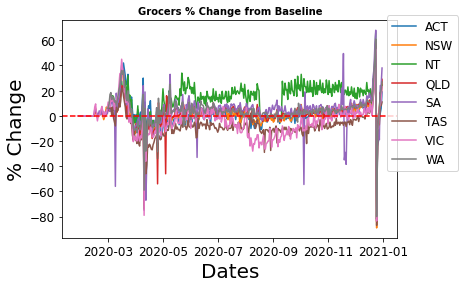

<Figure size 720x3600 with 0 Axes>

In [22]:
#Grocers review to show net possitive
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['grocery_pharmacy_pctchange_to_baseline']
nsw = nsw_df['grocery_pharmacy_pctchange_to_baseline']
nt = nt_df['grocery_pharmacy_pctchange_to_baseline']
qld = qld_df['grocery_pharmacy_pctchange_to_baseline']
sa = sa_df['grocery_pharmacy_pctchange_to_baseline']
tas = tas_df['grocery_pharmacy_pctchange_to_baseline']
vic = vic_df['grocery_pharmacy_pctchange_to_baseline']
wa = wa_df['grocery_pharmacy_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Grocers % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))

plt.show()


<Figure size 720x3600 with 0 Axes>

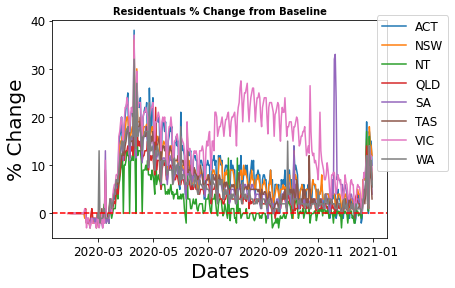

<Figure size 720x3600 with 0 Axes>

In [23]:
# Residentuals review to show net possitive
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['residential_pctchange_to_baseline']
nsw = nsw_df['residential_pctchange_to_baseline']
nt = nt_df['residential_pctchange_to_baseline']
qld = qld_df['residential_pctchange_to_baseline']
sa = sa_df['residential_pctchange_to_baseline']
tas = tas_df['residential_pctchange_to_baseline']
vic = vic_df['residential_pctchange_to_baseline']
wa = wa_df['residential_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Residentuals % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))

## Groceries Stores & Residence Observations - Assumptions
- We can see the areas that was hit the hardest was retail, parks, public transport and work places
- Movements to groceries and residentual areas did dropped but stay closed to baseline and actually had average increases to the baseline.  
- This indicate that these are essential locations and people will likely require movements around these areas despite a Pandemic situations and rising case numbers. 
- If anyhitng these locations will have greater increase to baseline, as other categories are seen as high risk due to rising case numbers 
- We will exclude these locations from indepth analysis.

## Reccomendations
- Our reccomendation is to increase public transport support and services around residentuals and groceries locations. Even when there are increase of case numbers as these are quiet essential.

## 2.4.2 Analysing Mobility Changes to Parks
Mobility trends for places like national parks, public beaches, marinas, dog parks, plazas and public gardens.

In [24]:
parks_avg_change = pd.DataFrame(parks_avg_change)
#drop 0 values
parks_avg_change = parks_avg_change[(parks_avg_change.T !=0).any()]
parks_avg_change

,parks_pctchange_to_baseline
state,
Australian Capital Territory,7.979592
New South Wales,-9.327941
Northern Territory,25.917492
Queensland,-3.913947
South Australia,-13.688060
Tasmania,-43.001639
Victoria,-20.257353
Western Australia,-13.859935


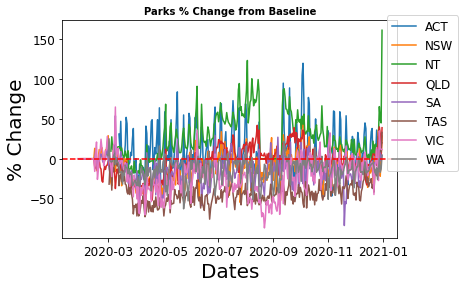

<Figure size 3600x3600 with 0 Axes>

In [25]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['parks_pctchange_to_baseline']
nsw = nsw_df['parks_pctchange_to_baseline']
nt = nt_df['parks_pctchange_to_baseline']
qld = qld_df['parks_pctchange_to_baseline']
sa = sa_df['parks_pctchange_to_baseline']
tas = tas_df['parks_pctchange_to_baseline']
vic = vic_df['parks_pctchange_to_baseline']
wa = wa_df['parks_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Parks % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(50, 50))
plt.show()

Text(0, 0.5, 'AU states')

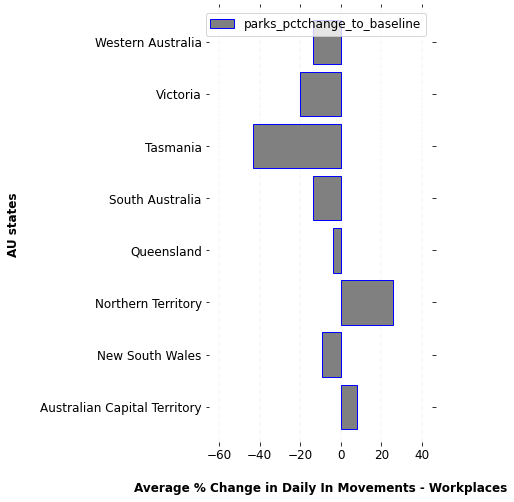

In [26]:
# Plot for visualisation
colors = ['grey']

x = parks_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Workplaces", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

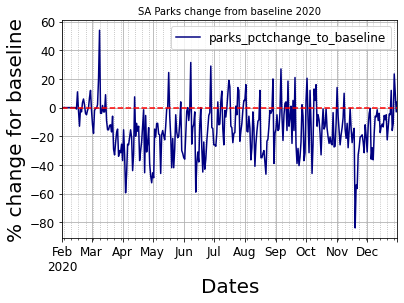

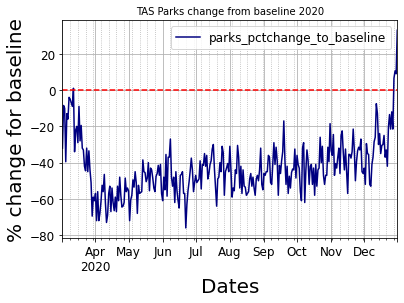

In [27]:
#SA
sa_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("SA Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#TAS
tas_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("TAS Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

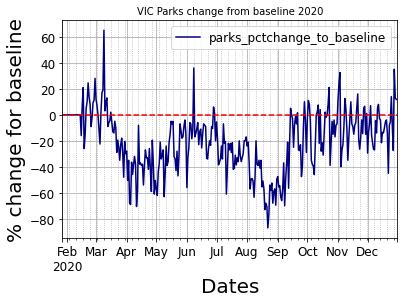

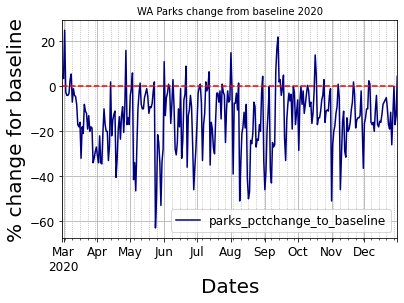

In [28]:
#VIC

vic_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("VIC Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#WA
wa_df.plot(kind = "line", x='date', y='parks_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("WA Parks change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## Parks Observations - Assumptions
- 

## Reccomendations
- 

## 2.4.3 Analysing Mobility Changes to Public Transport
Mobility trends for places that are public transport hubs, such as underground, bus and train stations.
Baseline is considered as zero, indicating no changes from prveious years.

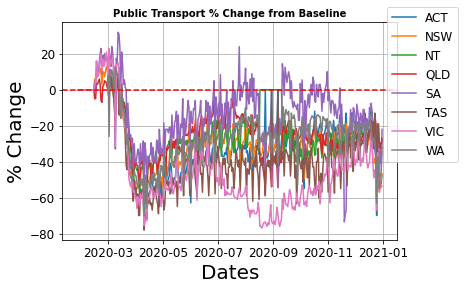

<Figure size 720x3600 with 0 Axes>

In [29]:
# Overview of this categrory for all states and how they look through out the year
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['transit_stations_pctchange_to_baseline']
nsw = nsw_df['transit_stations_pctchange_to_baseline']
nt = nt_df['transit_stations_pctchange_to_baseline']
qld = qld_df['transit_stations_pctchange_to_baseline']
sa = sa_df['transit_stations_pctchange_to_baseline']
tas = tas_df['transit_stations_pctchange_to_baseline']
vic = vic_df['transit_stations_pctchange_to_baseline']
wa = wa_df['transit_stations_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')
plt.grid(which='major', linestyle='-')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.title("Public Transport % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))

plt.show()


In [30]:
# looking at average over all changes to catching public transport to see which states were the most impacted
pt_avg_change = pd.DataFrame(pt_avg_change)
#drop 0 values
pt_avg_change = pt_avg_change[(pt_avg_change.T !=0).any()]
pt_avg_change

,transit_stations_pctchange_to_baseline
state,
Australian Capital Territory,-34.108844
New South Wales,-27.429412
Northern Territory,-27.140264
Queensland,-23.713650
South Australia,-13.026866
Tasmania,-41.149180
Victoria,-43.850000
Western Australia,-26.973941


Text(0, 0.5, 'AU states')

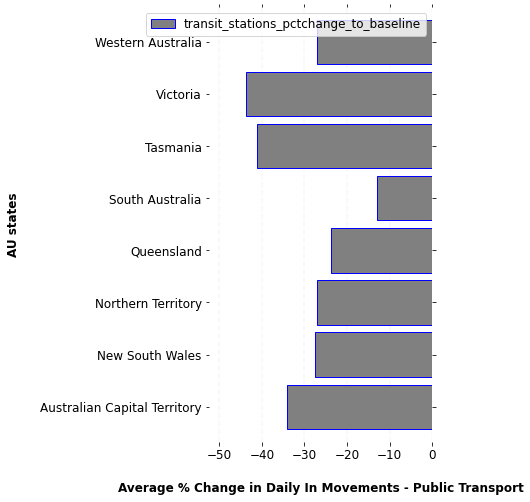

In [31]:
# Plot for visualisation
colors = ['grey']

x = pt_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Public Transport", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

### Observations - Public Transport Usage and COVID Cases Over Time

- All States saw an above base line usage of public transport at the begining of the year. This trend was increasing in Jan approaching March prior to the Pandemic status being declared.


- All states took a hard dip from Mar towards Apr after the pandemic anouncement was made and spike in confirmed COVID cases.


- The hard dip in public transport usage from Mar - Apr  was likely corrolated to the exponential growth in confirmed cases around the same time across all states.


- Any states that manages to flatten the curve and kept it flatten post the exponetial growth, seen a continual trend in public transport usage that is an upward trajectory towards baseline.


- Most states continue towards a general upward trajectory. Except for QLD SA VIC had another notable dip in Sep due to second wave and increases in number of confirmed cases.


- Whenever there is a hard spike in confirm cases, like that experiened by some states in Sep and Nov. we can see a reponse in hard drop of public transport ultilisation around the same time.


- After April NSW VIC and WA never made it back to baseline for the remainder of the 2020.


- Of all sattes VIC had the most confirmed cases and had continual rise in cases up until Sep. As a result VIC visit and ultilisation of public transport was the most furthest from baseline in Australia. Only in Sep then the curve flatten out was there a steady increase back towards baseline.

## Recommendations
Our recommendations to for the furture around public transport planning would be:
    
- To reduce level of public transports in anticipation of a public announcement that could potentially affect all Australians. i.e. another pandemic or natural disasters.
    
    
- For Covid an event leading up to rise in number of cases like a superspreader event. If there are a likelyhood of increases in the number of cases. it should be followed by reduction in public transports in anticipation for the  dips from baseline of public transport usage.
    
    
- Once the cases are under control and the curve is flattened for approximately 1 month, begin to slowly introduce more public transport as the usage levels will slowly climb back up towards baseline. 
    

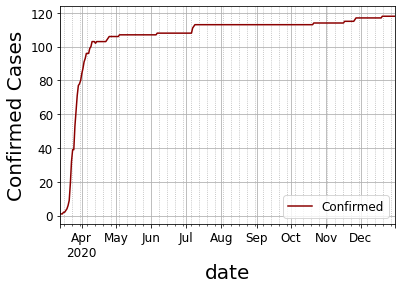

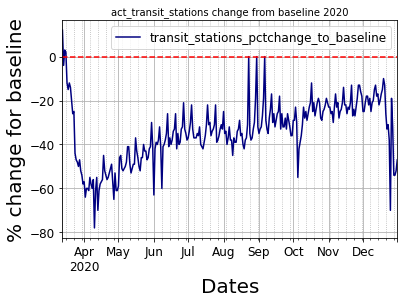

In [32]:
#Do individual analysis for every state

# ACT

#Plotting change in base line vs confirmcases for comparison
act_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

act_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("act_transit_stations change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

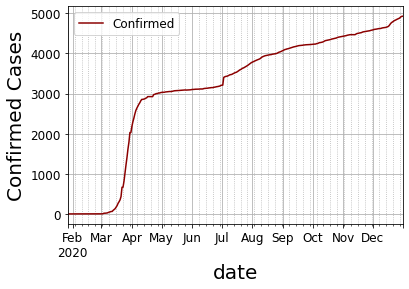

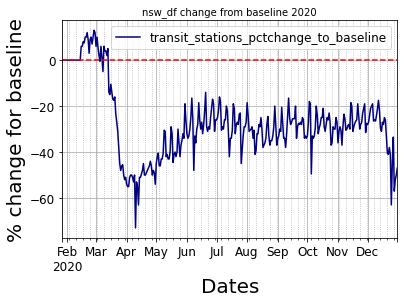

In [33]:
# NSW

#Plotting change in base line vs confirmcases for comparison
nsw_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


nsw_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("nsw_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

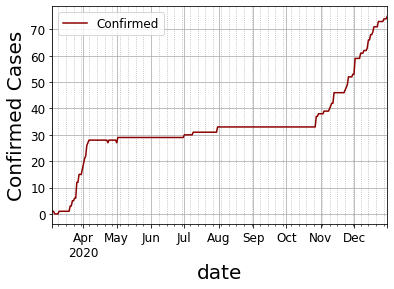

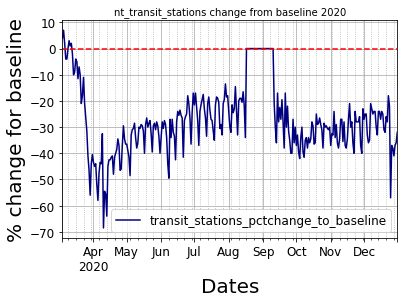

In [34]:
# NT

#Plotting change in base line vs confirmcases for comparison
nt_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

nt_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("nt_transit_stations change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

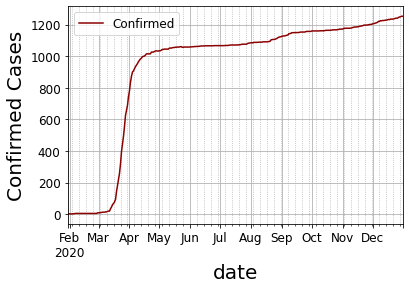

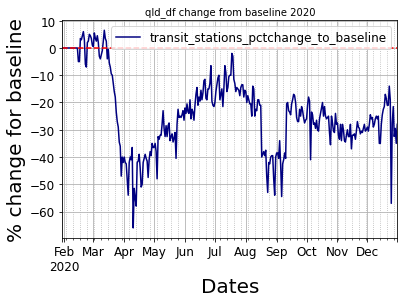

In [35]:
# QLD

#Plotting change in base line vs confirmcases for comparison
qld_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


qld_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("qld_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

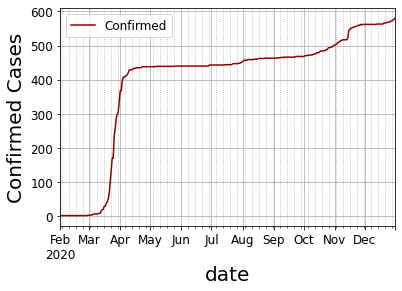

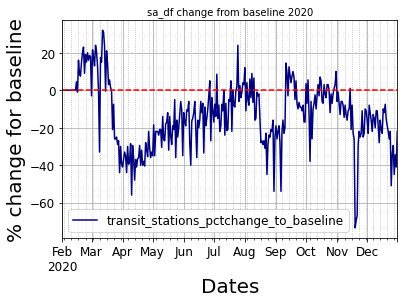

In [36]:
# SA

#Plotting change in base line vs confirmcases for comparison
sa_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


sa_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("sa_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')



plt.show()

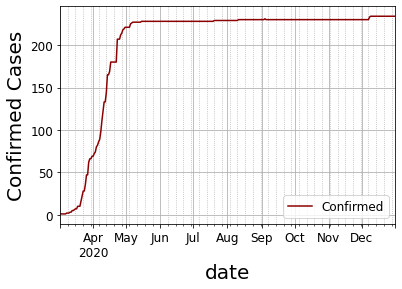

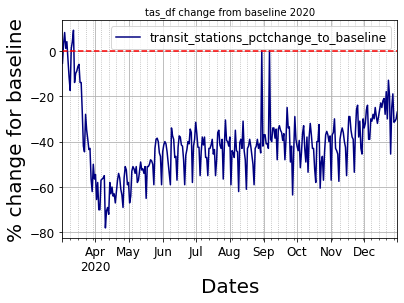

In [37]:
# TAS
# Plotting change in base line vs confirmcases for comparison
tas_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

tas_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("tas_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

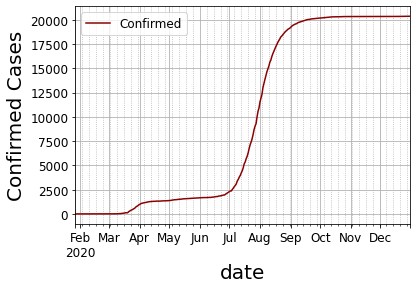

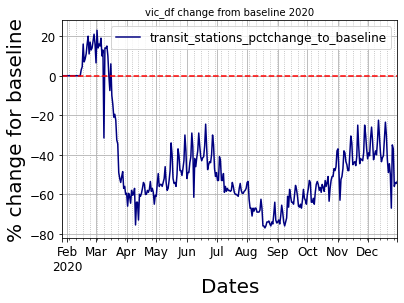

In [38]:
# VIC

#Plotting change in base line vs confirmcases for comparison
vic_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


vic_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("vic_df change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')


plt.show()

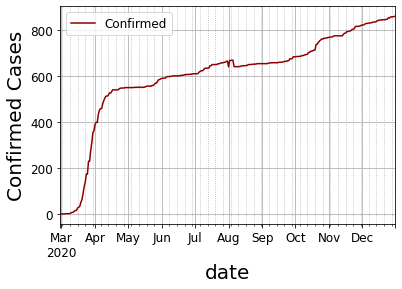

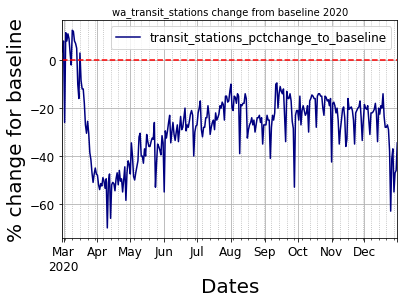

In [39]:
# WA
#Plotting change in base line vs confirmcases for comparison
wa_df.plot(kind = "line", x='date', y='Confirmed', color="darkred")
plt.ylabel('Confirmed Cases')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

wa_df.plot(kind = "line", x='date', y='transit_stations_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("wa_transit_stations change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## 2.4.4 Observed Mobility Changes to Workplace
Mobility trends for places of work.

- Similar observations can be made of steep declines from MAR - APR across all states. Possibly due to the announcement of Pandemic status and rising numbers of confirmed cases.

- However, mobility to workplaces has more steep declines throughout the year. Especially noticeable around the JUN, AUG & OCT periods. (lockdowns?)

- Most States managed to make their way back to or aboved baseline most a round the NOV - DEC period.

- All except VIC who never made it back to base line for 2020. This possibly due to VIC having the longest period of lockdowns out of all states.

## Recomendations
- COVID case numbers seems to have a delayed affect on movement to workplaces. Even when curve has flatten workplace policies and lockdowns can cause negative spikes. This must be factored in when reducing level of services.

In [40]:
workplace_avg_change = pd.DataFrame(workplace_avg_change)
#drop 0 values
workplace_avg_change = workplace_avg_change[(workplace_avg_change.T !=0).any()]
workplace_avg_change

,workplaces_pctchange_to_baseline
state,
Australian Capital Territory,-15.955782
New South Wales,-10.891176
Northern Territory,3.049505
Queensland,-6.942136
South Australia,-10.076119
Tasmania,-8.993443
Victoria,-22.116176
Western Australia,-8.581433


Text(0, 0.5, 'AU states')

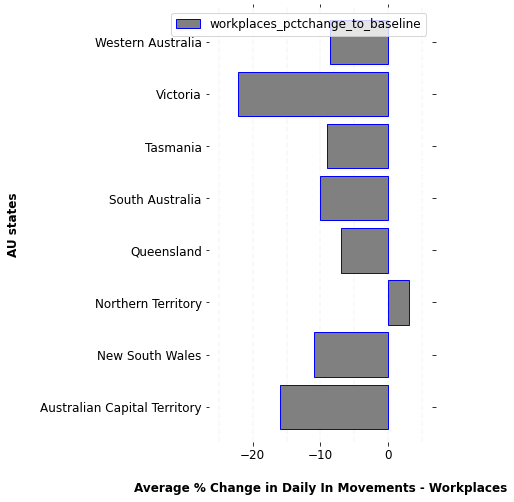

In [41]:
# Plot for visualisation
colors = ['grey']

x = workplace_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Workplaces", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

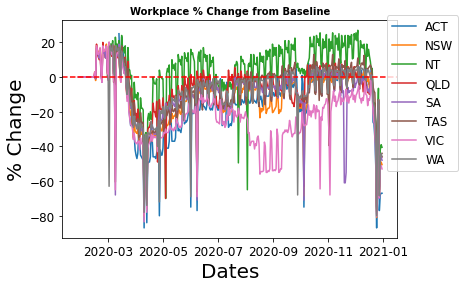

<Figure size 3600x3600 with 0 Axes>

In [42]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['workplaces_pctchange_to_baseline']
nsw = nsw_df['workplaces_pctchange_to_baseline']
nt = nt_df['workplaces_pctchange_to_baseline']
qld = qld_df['workplaces_pctchange_to_baseline']
sa = sa_df['workplaces_pctchange_to_baseline']
tas = tas_df['workplaces_pctchange_to_baseline']
vic = vic_df['workplaces_pctchange_to_baseline']
wa = wa_df['workplaces_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Workplace % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(50, 50))
plt.show()


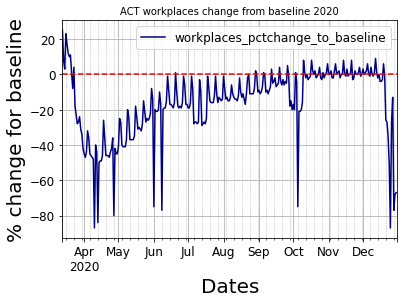

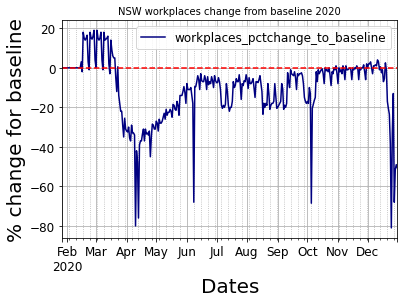

In [43]:
#ACT
act_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("ACT workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#NSW
nsw_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NSW workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

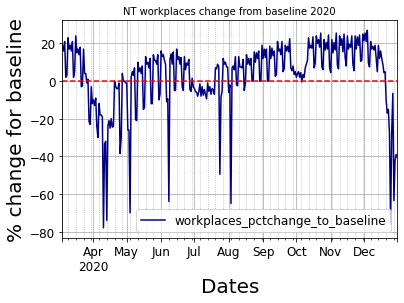

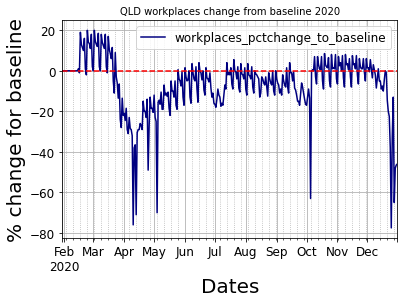

In [44]:
#NT
nt_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NT workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#QLD
qld_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("QLD workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

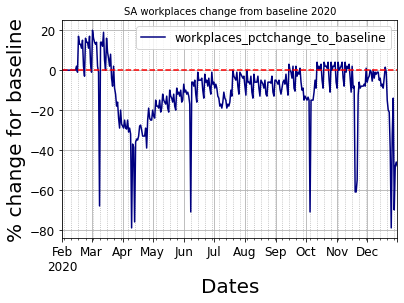

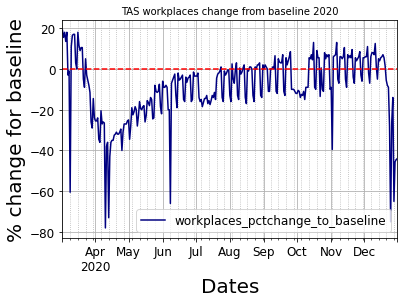

In [45]:
#SA
sa_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("SA workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#TAS
tas_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("TAS workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

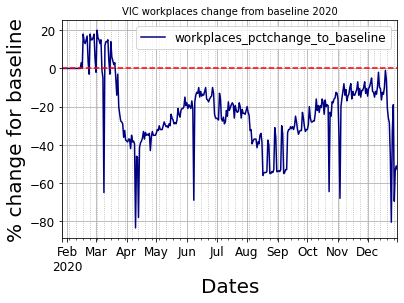

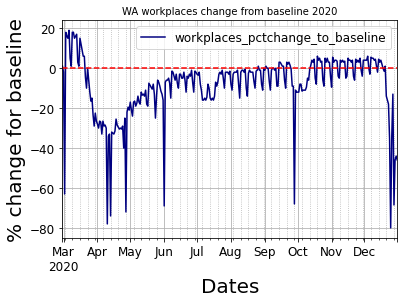

In [46]:
#VIC
vic_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("VIC workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#WA
wa_df.plot(kind = "line", x='date', y='workplaces_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("WA workplaces change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## 2.4.5 Observed Mobility Changes to Retail
Mobility trends for places such as restaurants, cafés, shopping centres,
theme parks, museums, libraries and cinemas.

In [47]:
retail_avg_change = pd.DataFrame(retail_avg_change)
#drop 0 values
retail_avg_change = retail_avg_change[(retail_avg_change.T !=0).any()]
retail_avg_change

,retail_recreation_pctchange_to_baseline
state,
Australian Capital Territory,-15.108844
New South Wales,-10.835294
Northern Territory,6.387789
Queensland,-4.688427
South Australia,-8.286567
Tasmania,-18.940984
Victoria,-25.023529
Western Australia,-4.809446


Text(0, 0.5, 'AU states')

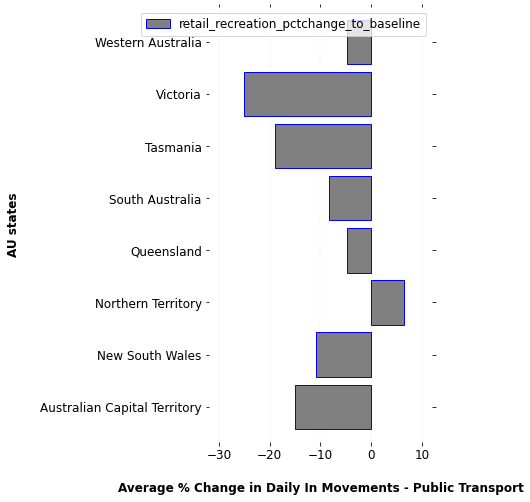

In [48]:
# Plot for visualisation
colors = ['grey']

x = retail_avg_change
ax = x.plot(kind='barh', figsize=(4, 8), color=[colors],edgecolor='blue', zorder=2, width=0.85)
  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Average % Change in Daily In Movements - Public Transport", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("AU states", labelpad=20, weight='bold', size=12)

### Observations - Public Transport Usage and COVID Cases Over Time
- Vitoria is again the most affected

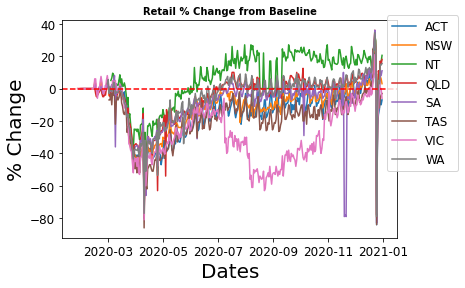

<Figure size 720x3600 with 0 Axes>

In [49]:
# Overview
#Plotting change in base line for all States on same chart
x1 = act_df['date']
x2 = nsw_df['date']
x3 = nt_df['date']
x4 = qld_df['date']
x5 = sa_df['date']
x6 = tas_df['date']
x7 = vic_df['date']
x8 = wa_df['date']

act = act_df['retail_recreation_pctchange_to_baseline']
nsw = nsw_df['retail_recreation_pctchange_to_baseline']
nt = nt_df['retail_recreation_pctchange_to_baseline']
qld = qld_df['retail_recreation_pctchange_to_baseline']
sa = sa_df['retail_recreation_pctchange_to_baseline']
tas = tas_df['retail_recreation_pctchange_to_baseline']
vic = vic_df['retail_recreation_pctchange_to_baseline']
wa = wa_df['retail_recreation_pctchange_to_baseline']

plt.plot(x1, act, label='ACT')
plt.plot(x2, nsw, label='NSW')
plt.plot(x3, nt,label='NT')
plt.plot(x4, qld, label='QLD')
plt.plot(x5, sa,label='SA')
plt.plot(x6, tas,label='TAS')
plt.plot(x7, vic, label='VIC')
plt.plot(x8, wa,label='WA')
plt.axhline(0.0,color='red', linestyle='--')

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.title("Retail % Change from Baseline", fontsize=10, fontweight='bold')
plt.xlabel("Dates")
plt.ylabel("% Change")
plt.figure(figsize=(10, 50))
plt.show()

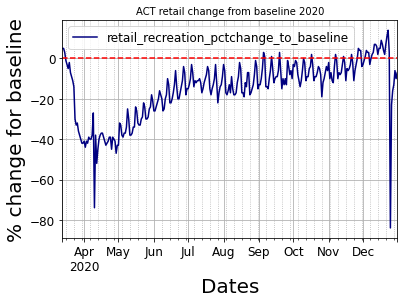

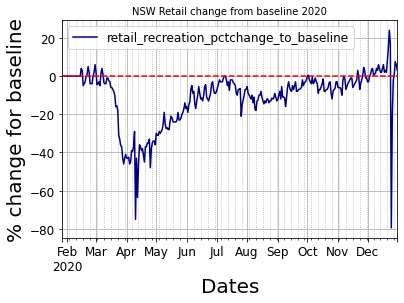

In [50]:
#ACT
act_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("ACT retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#NSW
nsw_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NSW Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

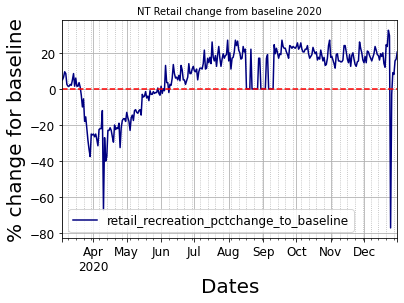

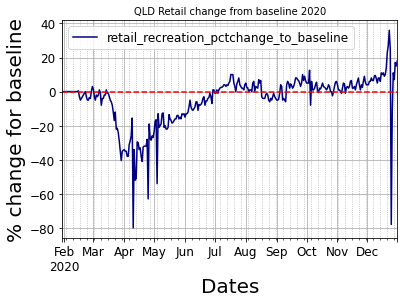

In [51]:
#NT
nt_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("NT Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#QLD
qld_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("QLD Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

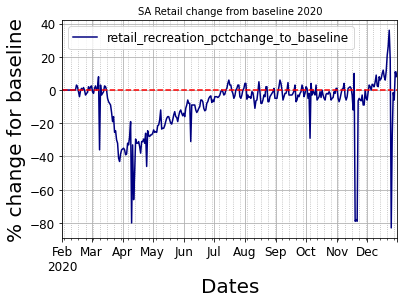

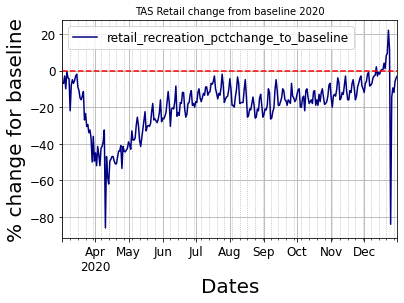

In [52]:
#SA
sa_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("SA Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#TAS
tas_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("TAS Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

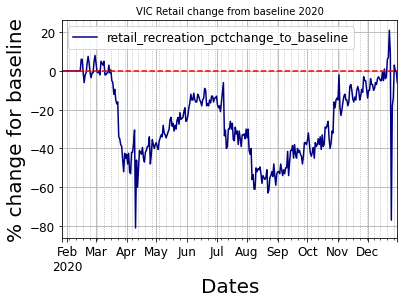

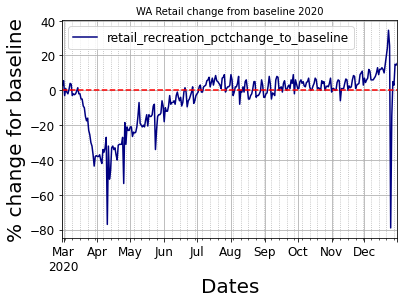

In [53]:
#VIC
vic_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("VIC Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

#WA
wa_df.plot(kind = "line", x='date', y='retail_recreation_pctchange_to_baseline', color="navy")
plt.axhline(0.0,color='red', linestyle='--')
plt.title("WA Retail change from baseline 2020")
plt.xlabel('Dates')
plt.ylabel('% change for baseline')

plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

plt.show()

## **WIP! (Keep?)** Box Plot for Public Transport daily % change for regions
 - looking at the box plot data shown for public transport percentages changes for the year. We can see that they are mostly normally distributed except for VIC whic is slightly skewed. This mean that data can be more easily predicted as they follows the typical pattern for all normal distributions.

<ipython-input-54-84debd5613f4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels,rotation=90, fontsize=12)


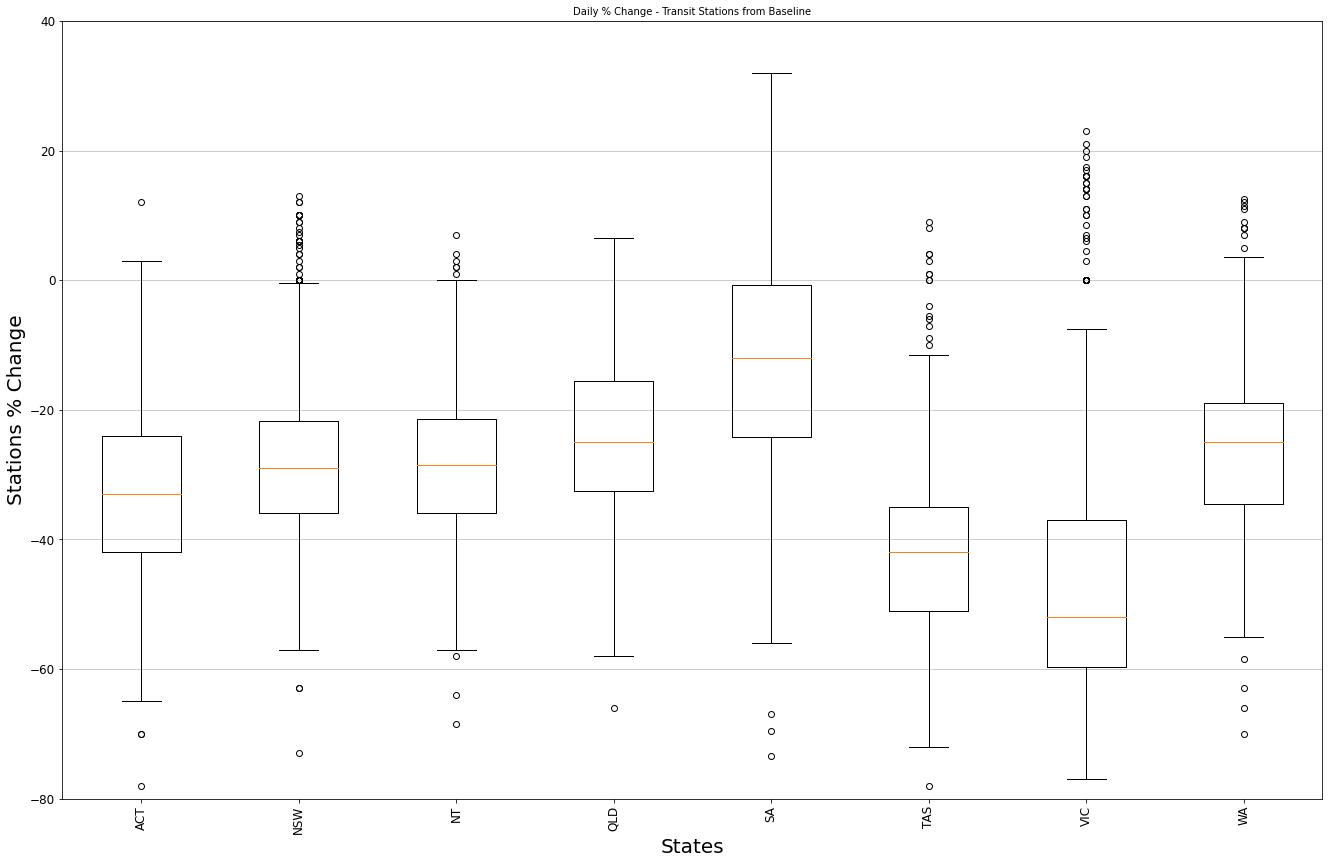

In [54]:
#Box PLots
# get PT daily % change for regions
act_station_plot = act_df["transit_stations_pctchange_to_baseline"]
nsw_station_plot = nsw_df["transit_stations_pctchange_to_baseline"]
nt_station_plot = nt_df["transit_stations_pctchange_to_baseline"]
qld_station_plot = qld_df["transit_stations_pctchange_to_baseline"]
sa_station_plot = sa_df["transit_stations_pctchange_to_baseline"]
tas_station_plot = tas_df["transit_stations_pctchange_to_baseline"]
vic_station_plot = vic_df["transit_stations_pctchange_to_baseline"]
wa_station_plot = wa_df["transit_stations_pctchange_to_baseline"]

# Generate a box plot for each region for analysis
stations_percent_change_boxplot = [act_station_plot, nsw_station_plot, nt_station_plot, qld_station_plot,sa_station_plot,tas_station_plot,vic_station_plot, wa_station_plot]

#ax1.boxplot(stations_percent_change_boxplot)

fig, ax1 = plt.subplots(figsize=(20, 12),)
fig.subplots_adjust(left=0.075, right=0.95, top=1.0, bottom=0.1)

# Set the axes ranges and axes labels
labels=["ACT","NSW","NT","QLD","SA","TAS","VIC","WA"]

ax1.set_xlim(0.5, 8.5)
ax1.set_ylim(-80, 40)
ax1.set_xticklabels(labels,rotation=90, fontsize=12)

ax1.yaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
               
ax1.set(axisbelow=True, title="Daily % Change - Transit Stations from Baseline",xlabel='States', ylabel='Stations % Change',)
        

ax1.boxplot(stations_percent_change_boxplot)

plt.show()

## Kevin's Section

## Mehrdad's Sections

## 3.1 Heat Maps and Correlations

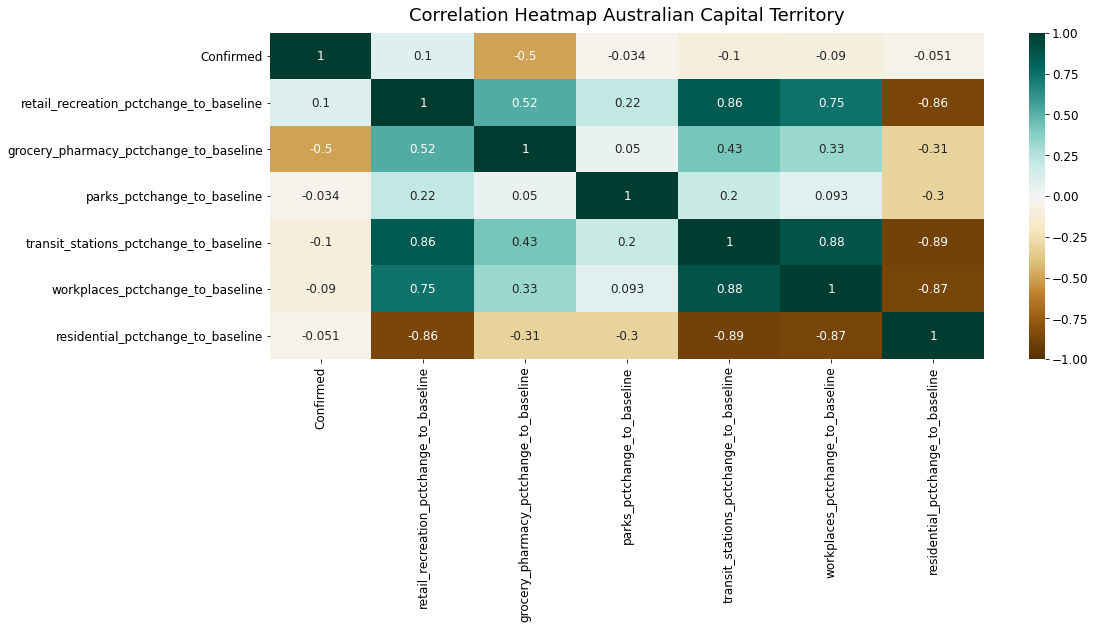

In [57]:
#import the library seaborn for having better heatmap and correlation
import seaborn as sns


#Select the specific columns which can affected together

corract_df=act_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corract_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Australian Capital Territory', fontdict={'fontsize':18}, pad=12);

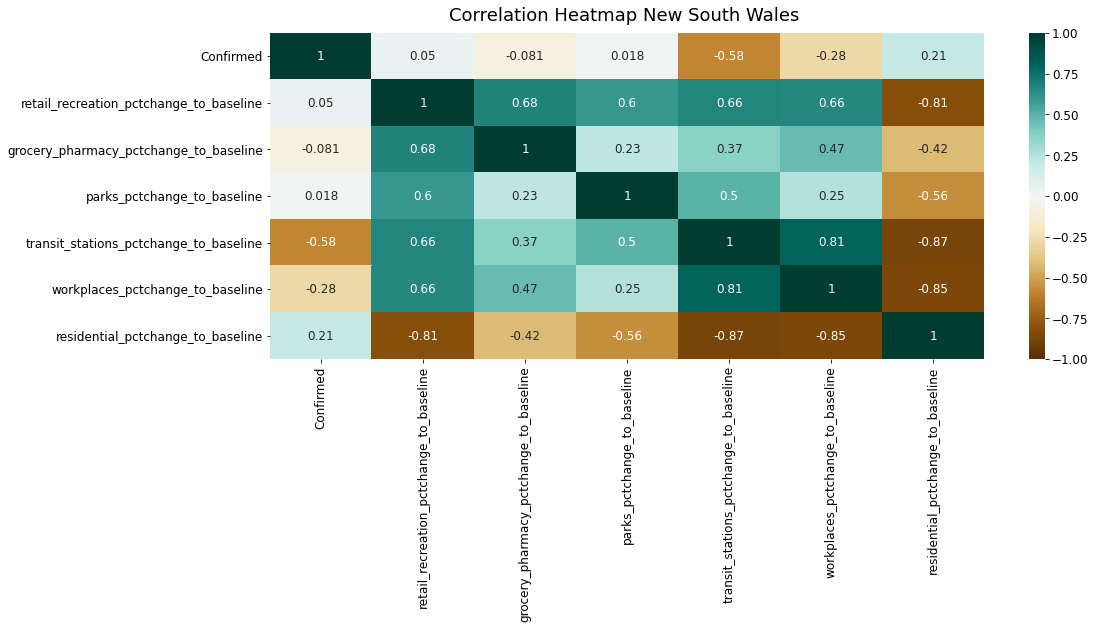

In [58]:
#Select the specific columns which can affected together
corrnsw_df=nsw_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrnsw_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap New South Wales ', fontdict={'fontsize':18}, pad=12);

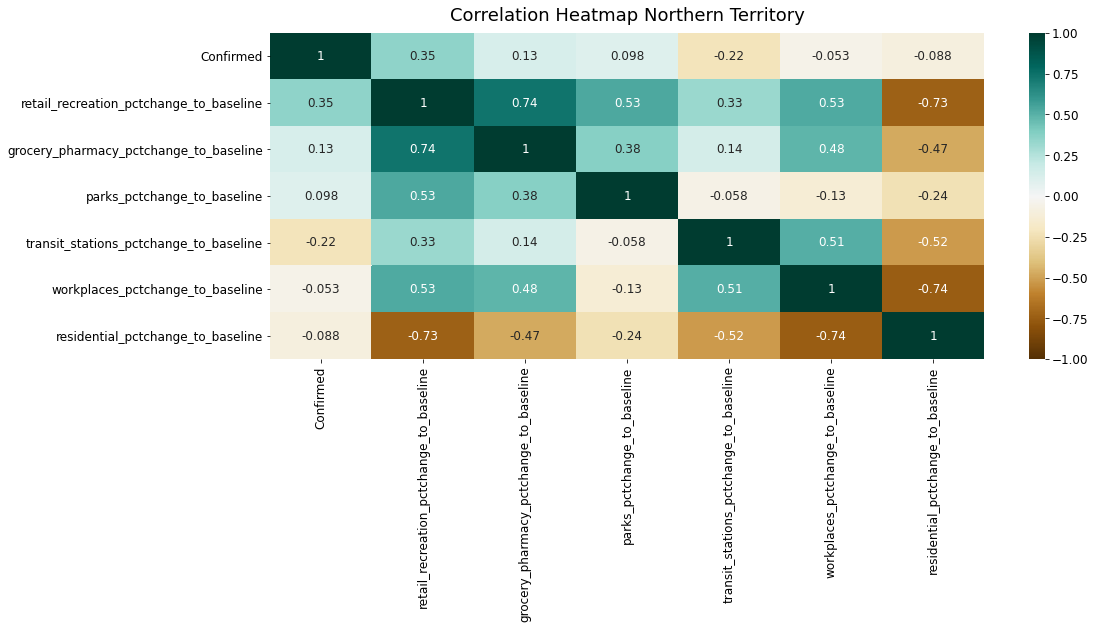

In [59]:
#Select the specific columns which can affected together
corrnt_df=nt_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrnt_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Northern Territory', fontdict={'fontsize':18}, pad=12);

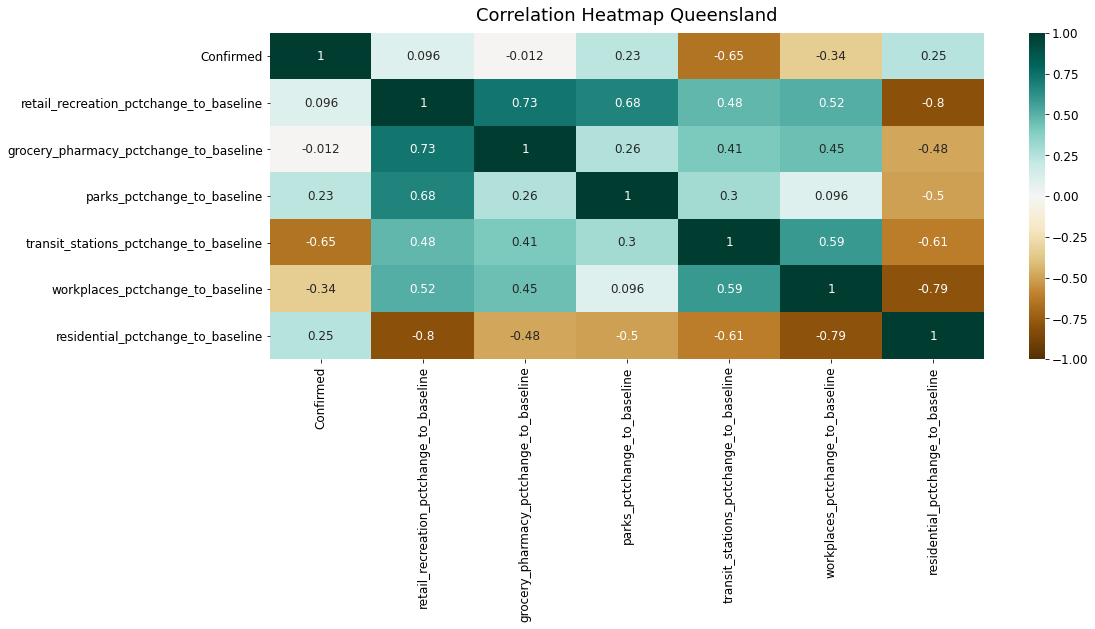

In [60]:
#Select the specific columns which can affected together
corrqld_df=qld_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrqld_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Queensland', fontdict={'fontsize':18}, pad=12);

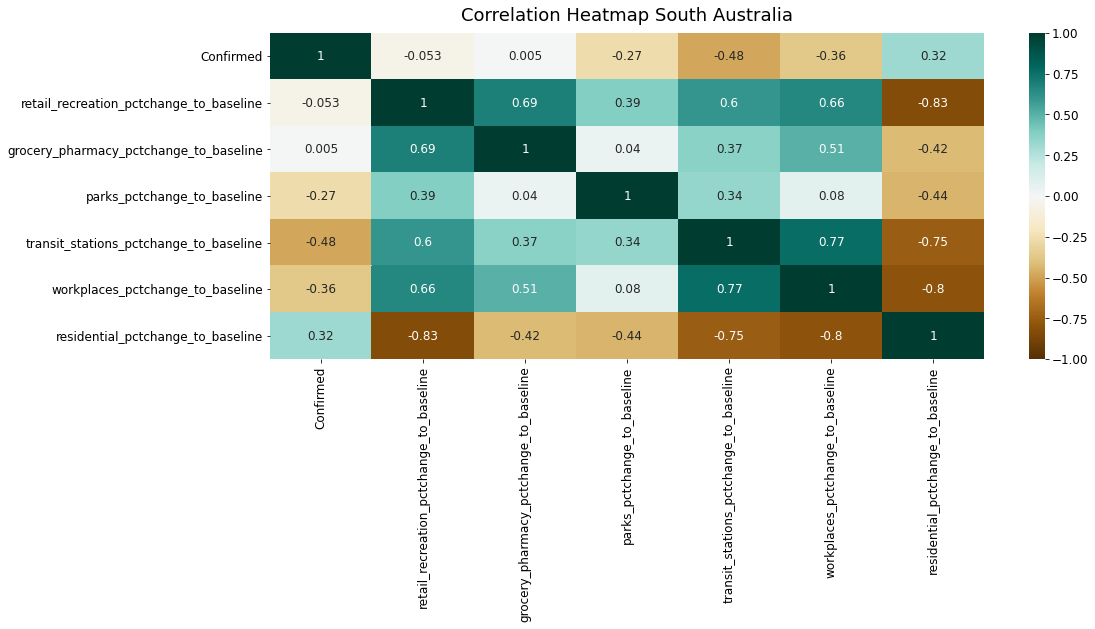

In [61]:
#Select the specific columns which can affected together
corrsa_df=sa_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrsa_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap South Australia', fontdict={'fontsize':18}, pad=12);

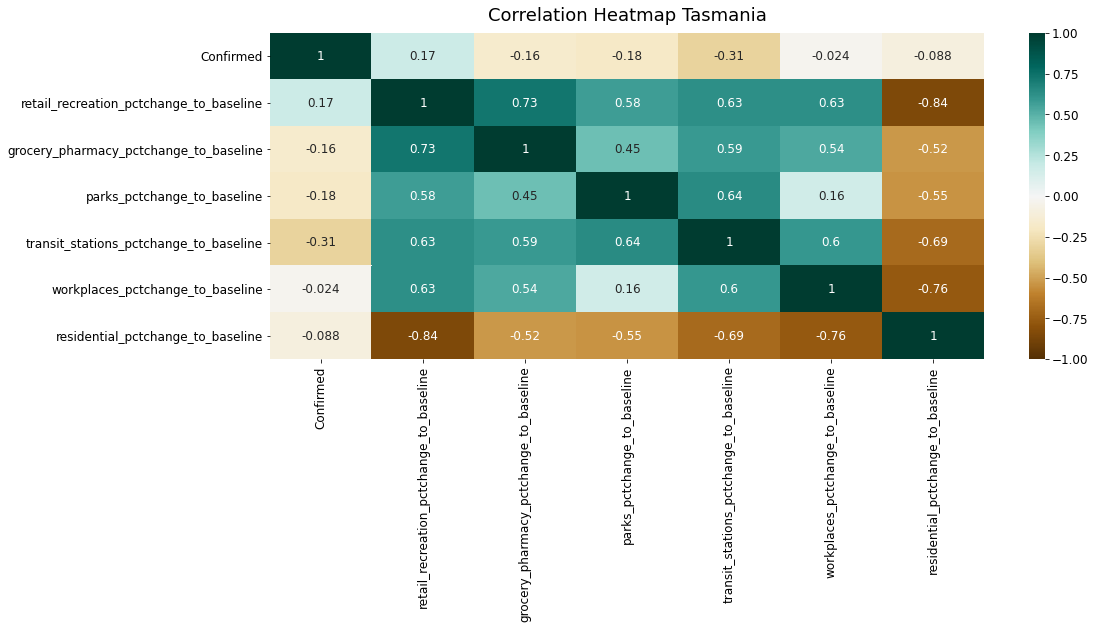

In [62]:
#Select the specific columns which can affected together
corrtas_df=tas_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrtas_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Tasmania', fontdict={'fontsize':18}, pad=12);

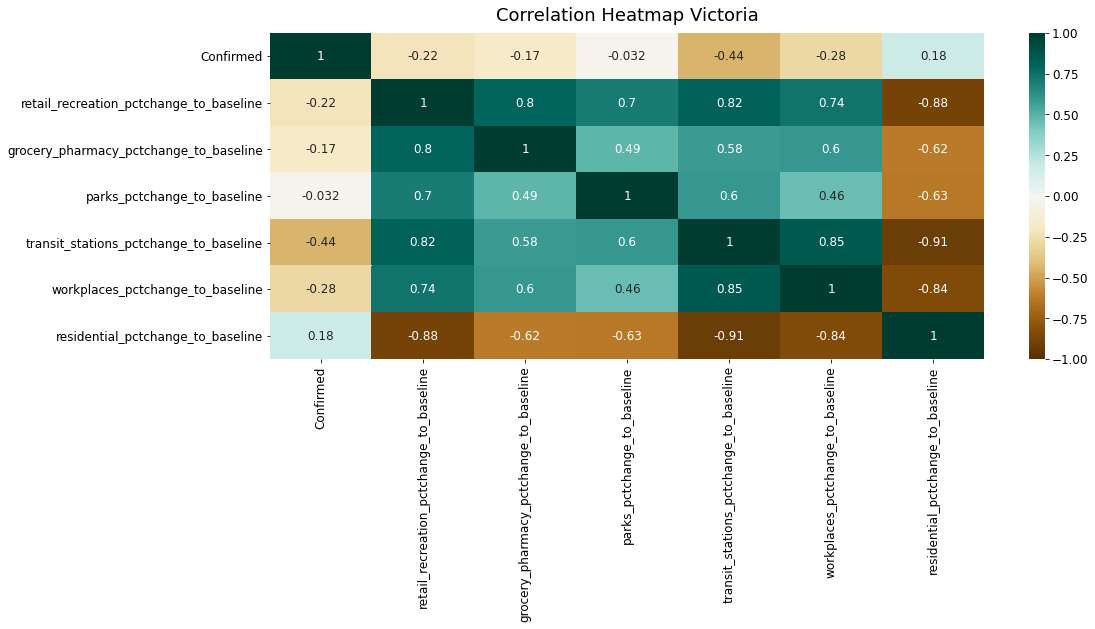

In [63]:
#Select the specific columns which can affected together
corrvic_df=vic_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrvic_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Victoria', fontdict={'fontsize':18}, pad=12);

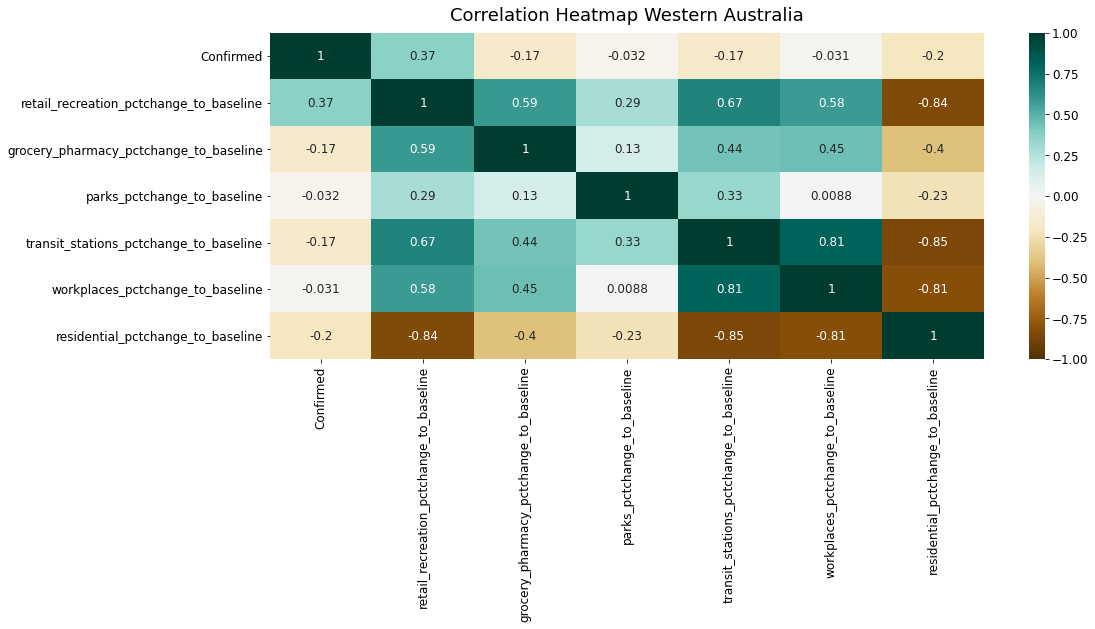

In [69]:

#Select the specific columns which can affected together
corrwa_df=wa_df[['Confirmed','retail_recreation_pctchange_to_baseline','grocery_pharmacy_pctchange_to_baseline',
                   'parks_pctchange_to_baseline','transit_stations_pctchange_to_baseline',
                  'workplaces_pctchange_to_baseline','residential_pctchange_to_baseline']]


plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corrwa_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Western Australia', fontdict={'fontsize':18}, pad=12);

## 3.2 T-Tests & P-Values Testing Hypothesis

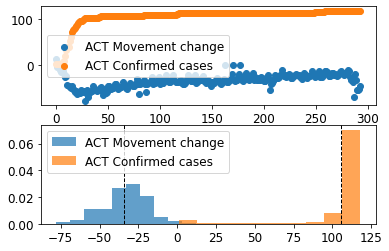

---------------------------------------------------------------------------------------------------------------
For state ACT the P-value between Movement change and Confirmed cases is  2.3240413e-317
---------------------------------------------------------------------------------------------------------------


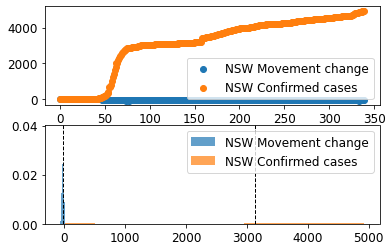

---------------------------------------------------------------------------------------------------------------
For state NSW the P-value between Movement change and Confirmed cases is  1.3578113054247993e-123
---------------------------------------------------------------------------------------------------------------


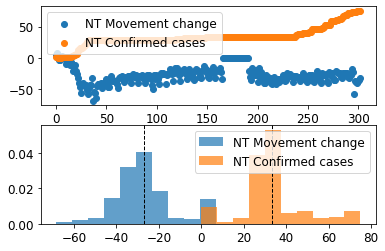

---------------------------------------------------------------------------------------------------------------
For state NT the P-value between Movement change and Confirmed cases is  2.0849354321916127e-226
---------------------------------------------------------------------------------------------------------------


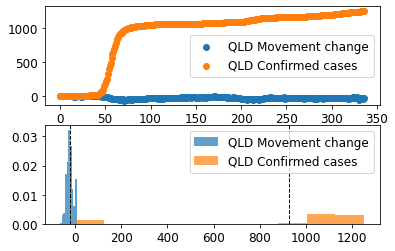

---------------------------------------------------------------------------------------------------------------
For state QLD the P-value between Movement change and Confirmed cases is  1.5134332553977494e-138
---------------------------------------------------------------------------------------------------------------


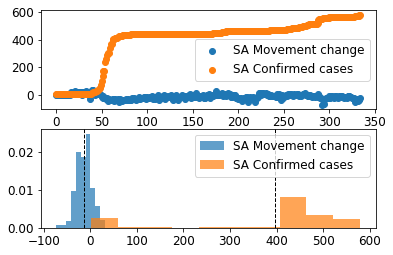

---------------------------------------------------------------------------------------------------------------
For state SA the P-value between Movement change and Confirmed cases is  1.3218052467861697e-139
---------------------------------------------------------------------------------------------------------------


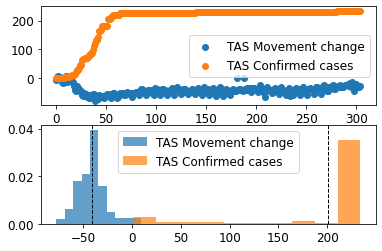

---------------------------------------------------------------------------------------------------------------
For state TAS the P-value between Movement change and Confirmed cases is  1.0694291294986678e-184
---------------------------------------------------------------------------------------------------------------


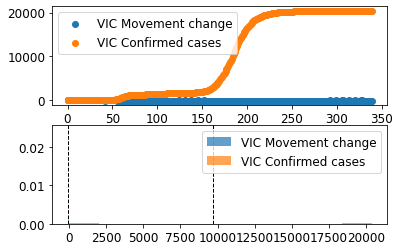

---------------------------------------------------------------------------------------------------------------
For state VIC the P-value between Movement change and Confirmed cases is  1.506857351217396e-58
---------------------------------------------------------------------------------------------------------------


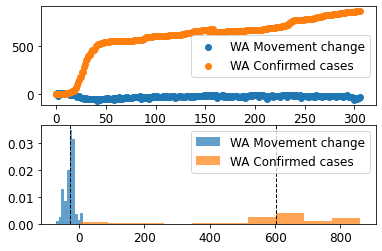

---------------------------------------------------------------------------------------------------------------
For state WA the P-value between Movement change and Confirmed cases is  6.259721923437233e-159
---------------------------------------------------------------------------------------------------------------


In [66]:
states_df=[act_df,nsw_df,nt_df,qld_df,sa_df,tas_df,vic_df ,wa_df]
mylegend=["ACT","NSW","NT","QLD","SA","TAS","VIC" ,"WA"]

for state,mystate in zip(states_df,mylegend):
    population1 = state['transit_stations_pctchange_to_baseline'] 
    population2 = state['Confirmed'] 
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1 ,label='%s Movement change'%mystate)
    plt.scatter(range(len(population2)), population2,label='%s Confirmed cases'%mystate)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(population1, 10, density=True, alpha=0.7, label='%s Movement change'%mystate)
    plt.hist(population2, 10, density=True, alpha=0.7, label='%s Confirmed cases'%mystate)
    plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------")
    print("For state",mystate, "the P-value between Movement change and Confirmed cases is ", stats.ttest_ind(population1, population2, equal_var=False)[1])
    print("---------------------------------------------------------------------------------------------------------------")
    

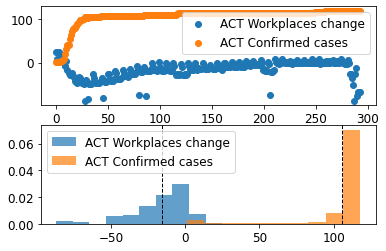

---------------------------------------------------------------------------------------------------------------
For state ACT the P-value between Workplaces change and Confirmed cases is  1.0538981507508991e-288
---------------------------------------------------------------------------------------------------------------


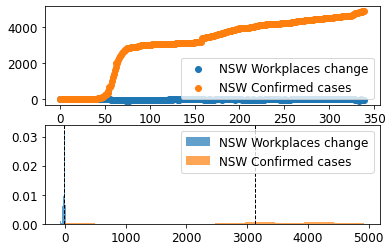

---------------------------------------------------------------------------------------------------------------
For state NSW the P-value between Workplaces change and Confirmed cases is  5.739105592037957e-123
---------------------------------------------------------------------------------------------------------------


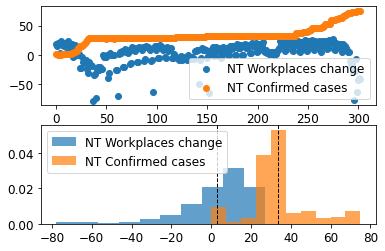

---------------------------------------------------------------------------------------------------------------
For state NT the P-value between Workplaces change and Confirmed cases is  1.6748133633481455e-81
---------------------------------------------------------------------------------------------------------------


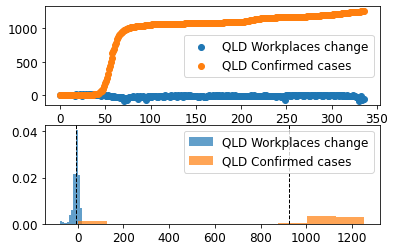

---------------------------------------------------------------------------------------------------------------
For state QLD the P-value between Workplaces change and Confirmed cases is  2.3848757346877173e-136
---------------------------------------------------------------------------------------------------------------


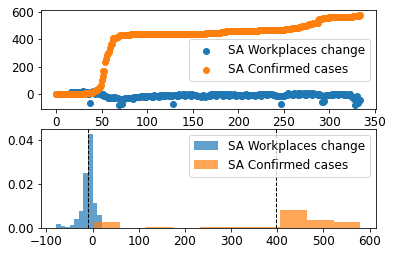

---------------------------------------------------------------------------------------------------------------
For state SA the P-value between Workplaces change and Confirmed cases is  1.526255614100864e-138
---------------------------------------------------------------------------------------------------------------


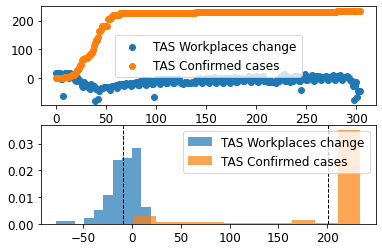

---------------------------------------------------------------------------------------------------------------
For state TAS the P-value between Workplaces change and Confirmed cases is  8.811960401813315e-167
---------------------------------------------------------------------------------------------------------------


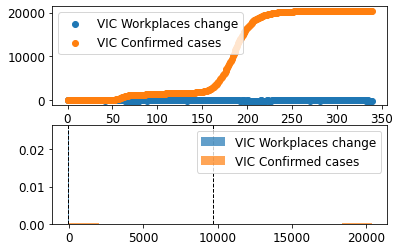

---------------------------------------------------------------------------------------------------------------
For state VIC the P-value between Workplaces change and Confirmed cases is  2.26351435738306e-58
---------------------------------------------------------------------------------------------------------------


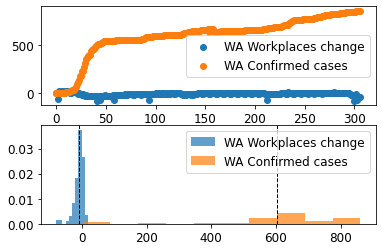

---------------------------------------------------------------------------------------------------------------
For state WA the P-value between Workplaces change and Confirmed cases is  1.7644848065782435e-155
---------------------------------------------------------------------------------------------------------------


In [67]:
for state,mystate in zip(states_df,mylegend):
    population1 = state['workplaces_pctchange_to_baseline'] 
    population2 = state['Confirmed'] 
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1 ,label='%s Workplaces change'%mystate)
    plt.scatter(range(len(population2)), population2,label='%s Confirmed cases'%mystate)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(population1, 10, density=True, alpha=0.7, label='%s Workplaces change'%mystate)
    plt.hist(population2, 10, density=True, alpha=0.7, label='%s Confirmed cases'%mystate)
    plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------")
    print("For state",mystate, "the P-value between Workplaces change and Confirmed cases is ", stats.ttest_ind(population1, population2, equal_var=False)[1])
    print("---------------------------------------------------------------------------------------------------------------")
    

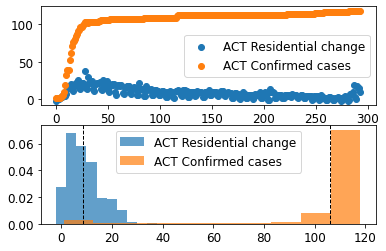

---------------------------------------------------------------------------------------------------------------
For state ACT the P-value between Residential change and Confirmed cases is  9.825651261405158e-213
---------------------------------------------------------------------------------------------------------------


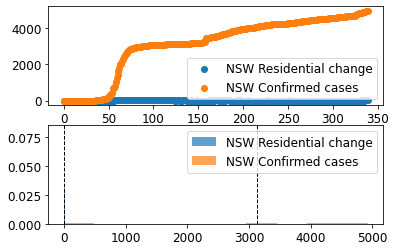

---------------------------------------------------------------------------------------------------------------
For state NSW the P-value between Residential change and Confirmed cases is  2.7277104403060676e-122
---------------------------------------------------------------------------------------------------------------


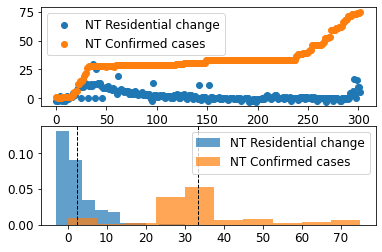

---------------------------------------------------------------------------------------------------------------
For state NT the P-value between Residential change and Confirmed cases is  3.0186042071573524e-116
---------------------------------------------------------------------------------------------------------------


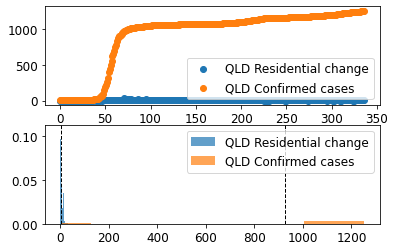

---------------------------------------------------------------------------------------------------------------
For state QLD the P-value between Residential change and Confirmed cases is  8.800419431322228e-135
---------------------------------------------------------------------------------------------------------------


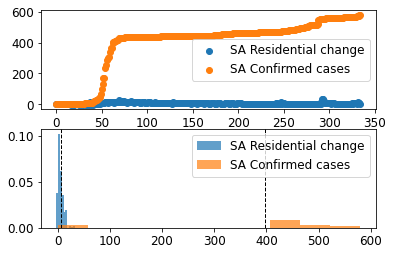

---------------------------------------------------------------------------------------------------------------
For state SA the P-value between Residential change and Confirmed cases is  4.3155583873129045e-133
---------------------------------------------------------------------------------------------------------------


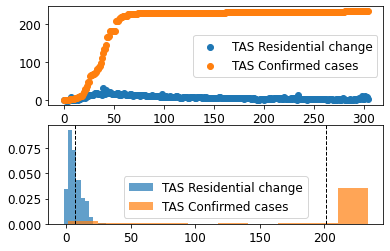

---------------------------------------------------------------------------------------------------------------
For state TAS the P-value between Residential change and Confirmed cases is  2.4693519425970324e-151
---------------------------------------------------------------------------------------------------------------


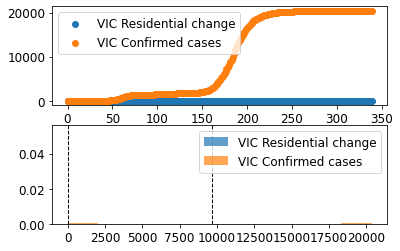

---------------------------------------------------------------------------------------------------------------
For state VIC the P-value between Residential change and Confirmed cases is  4.379404542937382e-58
---------------------------------------------------------------------------------------------------------------


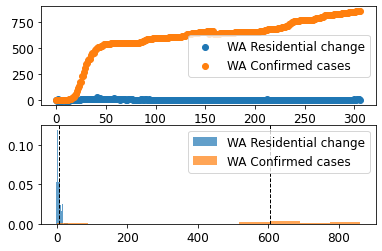

---------------------------------------------------------------------------------------------------------------
For state WA the P-value between Residential change and Confirmed cases is  4.502326096326552e-152
---------------------------------------------------------------------------------------------------------------


In [68]:
for state,mystate in zip(states_df,mylegend):
    population1 = state['residential_pctchange_to_baseline'] 
    population2 = state['Confirmed'] 
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1 ,label='%s Residential change'%mystate)
    plt.scatter(range(len(population2)), population2,label='%s Confirmed cases'%mystate)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(population1, 10, density=True, alpha=0.7, label='%s Residential change'%mystate)
    plt.hist(population2, 10, density=True, alpha=0.7, label='%s Confirmed cases'%mystate)
    plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------")
    print("For state",mystate, "the P-value between Residential change and Confirmed cases is ", stats.ttest_ind(population1, population2, equal_var=False)[1])
    print("---------------------------------------------------------------------------------------------------------------")
    

## Roy's Sections

## An's Section

## 5. 1 Data Distribution of Mobility Data
Determine if median is appropriately used to group the mobility data to state level.

Most of the mobility data are not normally distributed. Therefore, it is appropriate to use median as the measure of central tendency.

In [ ]:
# Data distribution of transit/station mobility

df=mobility_df[:]
df=df.dropna(subset=["sub_region_1"])
states = df["sub_region_1"].unique()

# Plot
fig, axes = plt.subplots(1, len(states), figsize=(25,3), dpi=100, sharex=True, sharey=True)

for i, (ax, sub_region_1) in enumerate(zip(axes.flatten(), df.sub_region_1.unique())):
    x = df.loc[df.sub_region_1==sub_region_1, 'transit_stations_percent_change_from_baseline']
    ax.hist(x, bins=45, density=True, stacked=True, label=str(sub_region_1))
    ax.set_title(sub_region_1)

plt.suptitle('Mobility Data Distribution - Transit/Station', y=1.05, size=20)
ax.set_xlim(-100, 100)
plt.tight_layout()

In [ ]:
# Data distribution of workplace mobility

df=mobility_df[:]
df=df.dropna(subset=["sub_region_1"])
states = df["sub_region_1"].unique()

# Plot
fig, axes = plt.subplots(1, len(states), figsize=(25,3), dpi=100, sharex=True, sharey=True)

for i, (ax, sub_region_1) in enumerate(zip(axes.flatten(), df.sub_region_1.unique())):
    x = df.loc[df.sub_region_1==sub_region_1, 'workplaces_percent_change_from_baseline']
    ax.hist(x, bins=45, density=True, stacked=True, label=str(sub_region_1))
    ax.set_title(sub_region_1)

plt.suptitle('Mobility Data Distribution - Workplace', y=1.05, size=20)
ax.set_xlim(-100, 50)
plt.tight_layout()

In [ ]:
# Data distribution of workplace mobility

df=mobility_df[:]
df=df.dropna(subset=["sub_region_1"])
states = df["sub_region_1"].unique()

# Plot
fig, axes = plt.subplots(1, len(states), figsize=(25,3), dpi=100, sharex=True, sharey=True)

for i, (ax, sub_region_1) in enumerate(zip(axes.flatten(), df.sub_region_1.unique())):
    x = df.loc[df.sub_region_1==sub_region_1, 'residential_percent_change_from_baseline']
    ax.hist(x, bins=45, density=True, stacked=True, label=str(sub_region_1))
    ax.set_title(sub_region_1)

plt.suptitle('Mobility Data Distribution - Residential', y=1.05, size=20)
ax.set_xlim(-10, 40)
plt.tight_layout()

## 5. 2 Finding NaN Sub_Region_1 (State) in Mobility Data

In [71]:
# Find place_id with NaN sub_region_1

na_df=mobility_df.loc[mobility_df["sub_region_1"].isnull(),:]
na_id=na_df["place_id"].unique()
print(na_id)

['ChIJ38WHZwf9KysRUhNblaFnglM']


In [72]:
# Search in Google Geocode API for state using place_id

# set up a parameters dictionary
params = {
"place_id": "ChIJ38WHZwf9KysRUhNblaFnglM",
"key": g_key
}
 
url = 'https://maps.googleapis.com/maps/api/geocode/json'  
response = requests.get(url, params=params).json()

pprint(response)

{'results': [{'address_components': [{'long_name': 'Australia',
                                      'short_name': 'AU',
                                      'types': ['country', 'political']}],
              'formatted_address': 'Australia',
              'geometry': {'bounds': {'northeast': {'lat': -9.187026399999999,
                                                    'lng': 159.2872223},
                                      'southwest': {'lat': -54.83376579999999,
                                                    'lng': 110.9510339}},
                           'location': {'lat': -25.274398, 'lng': 133.775136},
                           'location_type': 'APPROXIMATE',
                           'viewport': {'northeast': {'lat': -0.6911343999999999,
                                                      'lng': 166.7429167},
                                        'southwest': {'lat': -51.66332320000001,
                                                      'lng': 100.0911072}}

In [73]:
# Using Google Geocode API to retrieve coordinate

na_df=mobility_df.loc[mobility_df["sub_region_1"].isnull(),:]
na_id=na_df["place_id"].unique()

# Find coordinate to find nearest place
# set up lists to hold reponse info
lat = []
lng = []
place_id=[]

# Loop through the list of cities and perform a request for data on each
for i in na_id:
    
    # set up a parameters dictionary
    params = {
    "place_id": na_id,
    "key": g_key
    }

    
    # Google Geocode
    url = 'https://maps.googleapis.com/maps/api/geocode/json'  
    response = requests.get(url, params=params).json()
    
    
    try:
        lat.append(response["results"][0]["geometry"]["location"]["lat"])
        lng.append(response["results"][0]["geometry"]["location"]["lng"])
        place_id.append(i)
        
        print(f"Place Id ({na_id}) found. Appending...")
    
    except:
       # Append null values
       print(f"Place Id ({na_id}) not found. Skipping...")
    pass
print(f"{place_id}:{lat},{lng}")

Place Id (['ChIJ38WHZwf9KysRUhNblaFnglM']) found. Appending...
['ChIJ38WHZwf9KysRUhNblaFnglM']:[-25.274398],[133.775136]


In [74]:
# Using Goodle Place API to search for nearby places 
target_search = "airport"
target_radius = 100000
    
    # set up a parameters dictionary
params = {
    #"location": "-23.794707829614737, 133.90231753918897", #Alice Springs Airport
    "location": "-25.274398,133.775136",
    "keyword": target_search,
    "radius": target_radius,
    "key": g_key
    }

    
    # Google Place
place_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
place_response = requests.get(place_url, params=params).json()
    
pprint(place_response)

{'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'}


In [75]:
# Search closest city using citipy library (https://pypi.python.org/pypi/citipy)
cities = []
search_place_id = []

for x,y,i in zip(lat,lng,place_id):
    city=citipy.nearest_city(x,y)  
    cities.append(city.city_name)
    search_place_id.append(i)
print(cities)
print(search_place_id)

['alice springs']
['ChIJ38WHZwf9KysRUhNblaFnglM']


In [76]:
# Using Google Geocode API to retrieve state via address search
params = {
"address": "alice springs",
"key": g_key
}
 
url = 'https://maps.googleapis.com/maps/api/geocode/json'  
response = requests.get(url, params=params).json()

pprint(response)

{'results': [{'address_components': [{'long_name': 'Alice Springs',
                                      'short_name': 'Alice Springs',
                                      'types': ['locality', 'political']},
                                     {'long_name': 'Alice Springs Municipality',
                                      'short_name': 'Alice Springs',
                                      'types': ['administrative_area_level_2',
                                                'political']},
                                     {'long_name': 'Northern Territory',
                                      'short_name': 'NT',
                                      'types': ['administrative_area_level_1',
                                                'political']},
                                     {'long_name': 'Australia',
                                      'short_name': 'AU',
                                      'types': ['country', 'political']},
                           

In [77]:
# Use cities to search for state


# set up lists to hold reponse info
state = []
na_place_id=[]

# Loop through the list of cities and perform a request for data on each
for i,j in zip(cities,search_place_id):
    
    # set up a parameters dictionary
    params = {
    "address": cities,
    "key": g_key
    }

    
    # Google Geocode
    url = 'https://maps.googleapis.com/maps/api/geocode/json'  
    response = requests.get(url, params=params).json()
    
    
    try:
        state.append(response["results"][0]["address_components"][2]["long_name"])
        na_place_id.append(j)
        
        print(f"Place Id ({na_id}) found. Appending...")
    
    except:
       # Append null values
       print(f"Place Id ({na_id}) not found. Skipping...")
    pass
print(f"{state}:{na_place_id}")

Place Id (['ChIJ38WHZwf9KysRUhNblaFnglM']) found. Appending...
['Northern Territory']:['ChIJ38WHZwf9KysRUhNblaFnglM']


The above finding will be used to fix the original mobility data frame mobility_df

In [78]:
# Update NaN values in sub_region_1
mobility_df["sub_region_1"]=mobility_df.loc[(mobility_df["sub_region_1"].isnull()) 
                                            & (mobility_df['place_id']=="ChIJ38WHZwf9KysRUhNblaFnglM")] = "Northern Territory"

mobility_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AU,Australia,Northern Territory,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-15 00:00:00,4,3,-2,3,3,0
1,AU,Australia,Northern Territory,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-16 00:00:00,3,5,9,3,-1,0
2,AU,Australia,Northern Territory,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-17 00:00:00,-1,0,-6,7,17,-2
3,AU,Australia,Northern Territory,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-18 00:00:00,-3,-2,-13,7,14,-1
4,AU,Australia,Northern Territory,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-19 00:00:00,-1,-1,-6,8,13,-1
